with 300K combined model and 1M combined model

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

In [4]:
result = pd.read_csv('/Users/qingpeng/Dropbox/Genelearn/VicaData/all_2k_prediction.out.label.prediction_combined',sep=' ',header=None,names=['name','length','probability','prediction','vfam','pfam','diamond','label',
                                                                                       'score_euk_non_euk','pred_euk_non_euk','score_non_euk_virus','pred_non_euk_virus',
                                                                                      'score_virus_non_virus','pred_virus_non_virus'])

### Formular to calcuate hybrid probability score from score from old model and euk/non-euk model

In [5]:
result["hybrid_probability"] = (result["score_euk_non_euk"] * result["probability"])**0.5

In [6]:
result["hybrid_prediction"] = (result.hybrid_probability >0.5)

In [7]:
result.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,score_non_euk_virus,pred_non_euk_virus,score_virus_non_virus,pred_virus_non_virus,hybrid_probability,hybrid_prediction
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,0.996004,1.0,0.001954,0.0,0.000097,False
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.995278,1.0,0.000529,0.0,0.000032,False
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.996629,1.0,0.000761,0.0,0.000019,False
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.991967,1.0,0.000477,0.0,0.000021,False
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.990354,1.0,0.000617,0.0,0.000018,False


In [8]:
### Using MEGAN annotation to check model performance 


from ete2 import NCBITaxa
ncbi = NCBITaxa()
def get_top_label(tax_id):
    lineage = ncbi.get_lineage(tax_id)
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id

# get MEGAN annotation results

megan_annot = pd.read_csv('./Micromonas/all_2k_contigs.fa.diamond-ex-all_tax_ID.txt',sep='\t',header=None,names=['name','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)


In [9]:
ranks = ncbi.get_lineage(186616)

In [10]:
ranks

[1, 10239, 186616]

In [11]:
megan_annot.head()

,name,tax_id,rank,tax_name,top_label
0,NODE_646_length_5889_cov_28.079_g448_i0,1,no rank,root,N/A
1,NODE_667_length_5857_cov_28.2491_g448_i1,1,no rank,root,N/A
2,NODE_671_length_5843_cov_18.2623_g465_i0,1,no rank,root,N/A
3,NODE_806_length_5513_cov_46.199_g556_i0,1,no rank,root,N/A
4,NODE_807_length_5513_cov_37.6629_g556_i1,1,no rank,root,N/A


In [12]:
new_table = pd.merge(result,megan_annot, on=['name'])

In [13]:
prediction_300k_full = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.300k_full')

In [14]:
prediction_3M_train = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.3M_train')

In [15]:
prediction_1M_combined = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/all_2k_contigs.fa.prediction.1M_full_run2')

In [16]:
prediction_300k_full.rename(index=str,columns={"ID": "name", "Prob_class_1":"Prob_class_1_300k_full"},inplace=True)

In [17]:
prediction_3M_train.rename(index=str,columns={"ID": "name", "Prob_class_1":"Prob_class_1_3M_train"},inplace=True)

In [18]:
prediction_1M_combined.rename(index=str,columns={"ID": "name", "Prob_class_1":"Prob_class_1_1M_combined"},inplace=True)

In [19]:
new_table_merge1 = pd.merge(new_table,prediction_300k_full, how='left',on=['name'])

In [20]:
new_table_merge2 = pd.merge(new_table_merge1,prediction_3M_train, how='left',on=['name'])

In [21]:
new_table_merge3 = pd.merge(new_table_merge2,prediction_1M_combined, how='left',on=['name'])

### 7041 contigs as ground-truth virus-related, with hits to virus-related domains, or annotated as virus by MEGAN based on BlastX/Diamond alignment

In [22]:
len(new_table[new_table.label==1.0])

7041

### 208302 contigs with length >=2k, in TARA


In [23]:
len(new_table_300k_combined)

NameError: name 'new_table_300k_combined' is not defined

In [24]:
new_table_merge3["non_euk_label"] = (new_table_merge3.top_label!='Eukaryota')

In [25]:
new_table_merge3["micromonas_label"] = (new_table_merge3.tax_name=='Micromonas') |(new_table_merge3.tax_name=='Micromonas pusilla CCMP1545')|(
        new_table_merge3.tax_name=='Micromonas commoda')


#### "no rank" does not equal "no annotation"

In [26]:
def convert_top_label(top_label):
    if top_label == 'N/A':
        return 'no annotation'
    else:
        return 'with annotation'

In [27]:
new_table_merge3['annotation_label'] = new_table_merge3['top_label'].map(convert_top_label)

### Split the TARA contigs into 3 categories

- "Virus" has virus-related domain hits or annotated as "virus" by MEGAN
- "Non-virus" , no virus-related domain hits, annotated as some non-virus taxonomical group by MEGAN 
- "Unknown",  no virus-related domain hits, not annotated into any taxonomical group by MEGAN, top_label as "N/A"

#### subsample "non-virus" and "unknown" to have same number of "Virus" contigs - 6913

In [28]:
# "non-virus" data frame... non-virus and with annotation by MEGAN
df_nonvirus = new_table_merge3[new_table_merge3.label==0.0][new_table_merge3['annotation_label']== 'with annotation']
df_nonvirus_subsample = df_nonvirus.sample(n=7041, replace=False)
#df_nonvirus_subsample.to_csv('df_nonvirus_subsample.csv')

# "Unknown" data frame... and without annotation by MEGAN

df_unknown = new_table_merge3[new_table_merge3.label==0.0][new_table_merge3['annotation_label']== 'no annotation']
df_unknown_subsample = df_unknown.sample(n=7041, replace=False)
#df_unknown_subsample.to_csv('df_unknown_subsample.csv')

### "Virus" contigs...  has pfam hits or annotated as "virus" by MEGAN
df_virus = new_table_merge3[new_table_merge3.label==1.0]
#df_virus.to_csv('df_virus.csv')



/Users/qingpeng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/qingpeng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [65]:
len(df_unknown[df_unknown.Prob_class_1_3M_train>0.5])

3556

In [66]:
len(df_unknown[df_unknown.Prob_class_1_3M_train>0.9])

2131

In [67]:
len(df_unknown[df_unknown.Prob_class_1_3M_train>0.99])

857

In [68]:
len(df_unknown)

10983

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d784650>]], dtype=object)

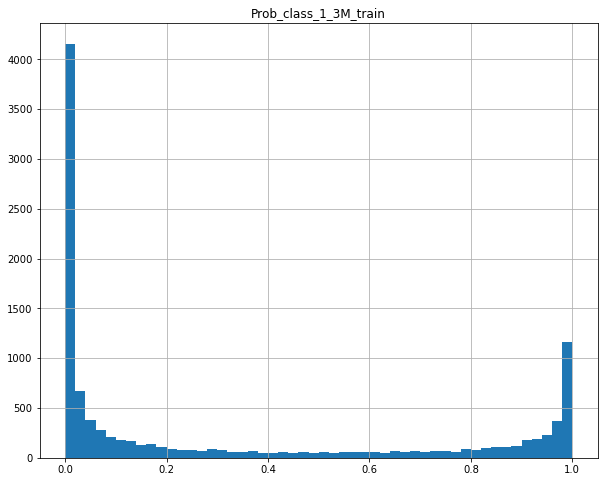

In [69]:
df_unknown.hist(figsize=(10,8),column=['Prob_class_1_3M_train'],bins=50)

In [29]:
def get_category(df):
    if df.label == 0.0:
        if df.annotation_label == 'with annotation':
            return 'nonvirus'
        else:
            return 'unknown'
    else:
        return 'virus'

In [30]:
new_table_merge3['category'] = new_table_merge3.apply(get_category, axis=1)

In [31]:
new_table_merge3.groupby('category').describe()


Class       Class_id     Class_id_x     Class_id_y  \
category                                                                     
nonvirus count  190211.000000  190211.000000  190211.000000  190211.000000   
         mean        1.818954       1.818954       1.762658       2.167298   
         std         0.687287       0.687287       0.728202       0.731501   
         min         0.000000       0.000000       0.000000       0.000000   
         25%         1.000000       1.000000       1.000000       2.000000   
         50%         2.000000       2.000000       2.000000       2.000000   
         75%         2.000000       2.000000       2.000000       3.000000   
         max         3.000000       3.000000       3.000000       3.000000   
unknown  count   10947.000000   10947.000000   10947.000000   10947.000000   
         mean        1.704120       1.704120       1.647209       2.022655   
         std         0.753010       0.753010       0.781520       0.843954   
         min         1.000000       1.000000       1.000000       1.000000   
         25%         1.000000       1.000000       1.000000       1.000000   
         50%         2.000000       2.000000       1.000000       2.000000   
         75%         2.000000       2.000000       2.000000       3.000000   
         max         3.000000       3.000000       3.000000       3.000000   
virus    count    7041.000000    7041.000000    7041.000000    7041.000000   
         mean        1.068456       1.068456       1.048573       1.268996   
         std         0.302688       0.302688       0.291301       0.645188   
         min         1.000000       1.000000       1.000000       1.000000   
         25%         1.000000       1.000000       1.000000       1.000000   
         50%         1.000000       1.000000       1.000000       1.000000   
         75%         1.000000       1.000000       1.000000       1.000000   
         max         3.000000       3.000000       3.000000       3.000000   

                      Class_x        Class_y  Prob_class_0  Prob_class_0_x  \
category                                                                     
nonvirus count  190211.000000  190211.000000  1.902110e+05    1.902110e+05   
         mean        1.762658       2.167298  5.005352e-03    7.842799e-03   
         std         0.728202       0.731501  1.071192e-02    1.263593e-02   
         min         0.000000       0.000000  0.000000e+00    0.000000e+00   
         25%         1.000000       2.000000  4.520020e-04    7.495335e-04   
         50%         2.000000       2.000000  2.440690e-03    4.295660e-03   
         75%         2.000000       3.000000  7.519225e-03    1.189770e-02   
         max         3.000000       3.000000  1.000000e+00    1.000000e+00   
unknown  count   10947.000000   10947.000000  1.094700e+04    1.094700e+04   
         mean        1.647209       2.022655  4.870173e-03    7.586935e-03   
         std         0.781520       0.843954  5.860103e-03    9.449481e-03   
         min         1.000000       1.000000  2.944600e-31    1.969550e-36   
         25%         1.000000       1.000000  4.325610e-04    4.740715e-04   
         50%         1.000000       2.000000  2.384410e-03    3.707370e-03   
         75%         2.000000       3.000000  7.542520e-03    1.177990e-02   
         max         3.000000       3.000000  3.744720e-02    9.041200e-02   
virus    count    7041.000000    7041.000000  7.041000e+03    7.041000e+03   
         mean        1.048573       1.268996  2.862356e-03    2.100517e-03   
         std         0.291301       0.645188  4.472367e-03    3.828359e-03   
         min         1.000000       1.000000  9.733260e-11    1.591990e-20   
         25%         1.000000       1.000000  1.762690e-04    7.414910e-05   
         50%         1.000000       1.000000  8.822800e-04    4.925100e-04   
         75%         1.000000       1.000000  3.439820e-03    2.250160e-03   
         max         3.000000       3.000000 

#### subsample "non-euk" to have same number of "euk" contigs, for evaluating euk/non-euk model

In [32]:
# "non-euk" data frame... non-virus and with annotation by MEGAN
df_euk = new_table_merge3[new_table_merge3.non_euk_label==False][new_table_merge3['annotation_label']== 'with annotation']

/Users/qingpeng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [33]:
len(df_euk)

40920

In [53]:
len(df_unknown)

10983

In [34]:
df_euk.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,Class,Class_id,Prob_class_0,Prob_class_1_1M_combined,Prob_class_2,Prob_class_3,non_euk_label,micromonas_label,annotation_label,category
268,NODE_269_length_13662_cov_37.4019_g165_i0,13662,1.000000,1.0,0.0,0.0,0.0,0.0,0.618436,1.0,...,1.0,1.0,4.383380e-04,9.175010e-01,0.007321,7.474000e-02,False,False,with annotation,nonvirus
326,NODE_327_length_11643_cov_43.6716_g200_i0,11643,0.000126,0.0,0.0,0.0,0.0,0.0,0.011231,0.0,...,2.0,2.0,5.389890e-04,2.665240e-04,0.975469,2.372530e-02,False,False,with annotation,nonvirus
348,NODE_349_length_11091_cov_73.7458_g215_i0,11091,0.000057,0.0,0.0,0.0,0.0,0.0,0.045895,0.0,...,2.0,2.0,7.116190e-04,4.866350e-04,0.905495,9.330670e-02,False,False,with annotation,nonvirus
517,NODE_518_length_8292_cov_38.7037_g335_i0,8292,0.002875,0.0,0.0,0.0,0.0,0.0,0.000803,0.0,...,2.0,2.0,7.540480e-04,2.957290e-03,0.978564,1.772480e-02,False,False,with annotation,nonvirus
522,NODE_523_length_8242_cov_224.933_g340_i0,8242,0.000006,0.0,0.0,0.0,0.0,0.0,0.022461,0.0,...,2.0,2.0,8.543460e-07,8.616370e-07,0.999998,3.514320e-08,False,False,with annotation,nonvirus


In [35]:
df_noneuk = new_table_merge3[new_table_merge3.non_euk_label==True][new_table_merge3['annotation_label']== 'with annotation']

/Users/qingpeng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [36]:
len(df_noneuk)

156078

In [37]:
df_noneuk_subsample = df_noneuk.sample(n=40920, replace=False)

In [38]:
df_virus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,Prob_class_3_y,Class,Class_id,Prob_class_0,Prob_class_1_1M_combined,Prob_class_2,Prob_class_3,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.507400,2.0,2.0,0.003184,0.006785,0.545710,0.444321,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.149424,1.0,1.0,0.006002,0.861805,0.106836,0.025357,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.353349,2.0,2.0,0.020173,0.244392,0.609811,0.125624,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.056174,1.0,1.0,0.002464,0.918208,0.064930,0.014399,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.782471,1.0,1.0,0.002768,0.844905,0.022769,0.129558,True,False,with annotation


In [39]:
df_micromonus = new_table_merge3[new_table_merge3.micromonas_label==True]

In [40]:
len(df_micromonus)

9586

In [41]:
df_micromonus.to_csv("Micromonas_table.csv")

In [42]:
df_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,Prob_class_3_y,Class,Class_id,Prob_class_0,Prob_class_1_1M_combined,Prob_class_2,Prob_class_3,non_euk_label,micromonas_label,annotation_label
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,...,7.056080e-13,2.0,2.0,1.060660e-07,0.000113,0.999887,4.107130e-15,True,False,with annotation
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,...,1.381120e-13,2.0,2.0,1.384510e-08,0.000006,0.999994,6.699520e-16,True,False,with annotation
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,...,8.154490e-11,2.0,2.0,1.072090e-07,0.000007,0.999993,1.115700e-12,True,False,with annotation
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,...,3.196500e-13,2.0,2.0,2.839570e-08,0.000024,0.999976,1.157360e-15,True,False,with annotation
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,...,1.307740e-11,2.0,2.0,5.799570e-08,0.000002,0.999998,2.616740e-13,True,False,with annotation


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122f22290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d464210>]], dtype=object)

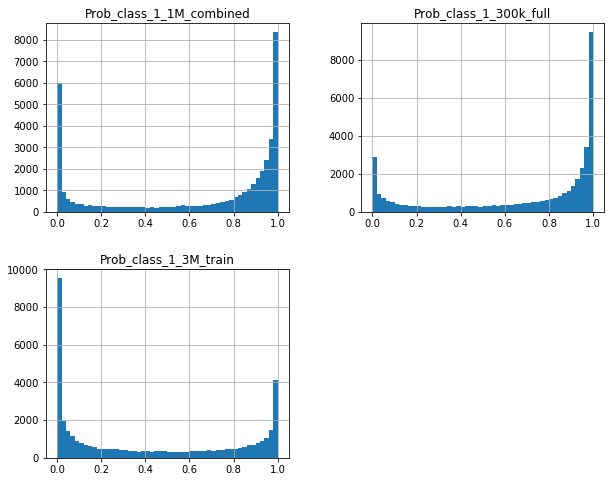

In [43]:
df_euk.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1245f0c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12719ce50>]], dtype=object)

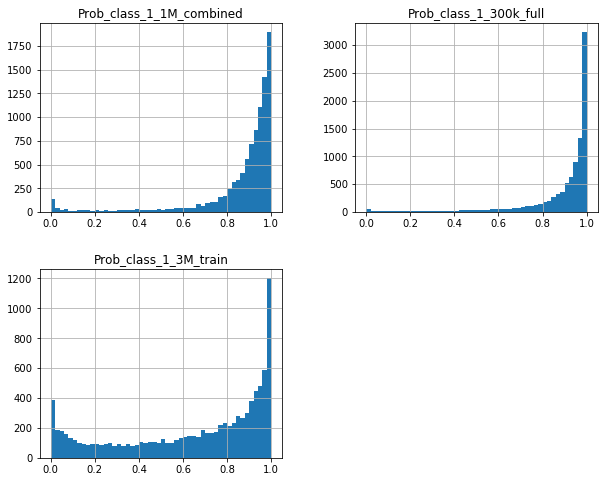

In [44]:
df_micromonus.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1272d7810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12ea37790>]], dtype=object)

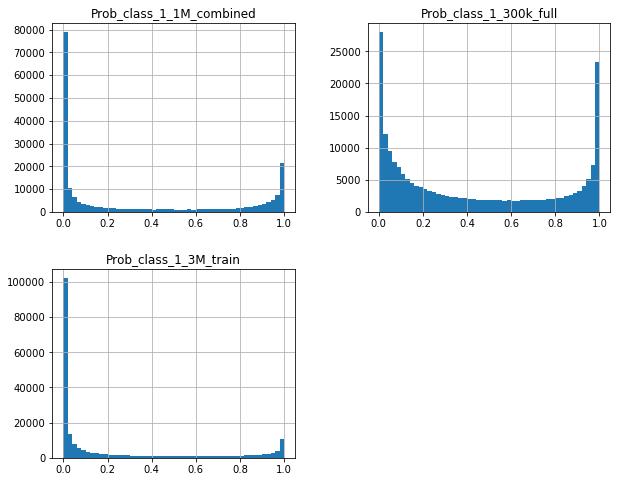

In [45]:
new_table_merge3.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f89c7d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12fd6a410>]], dtype=object)

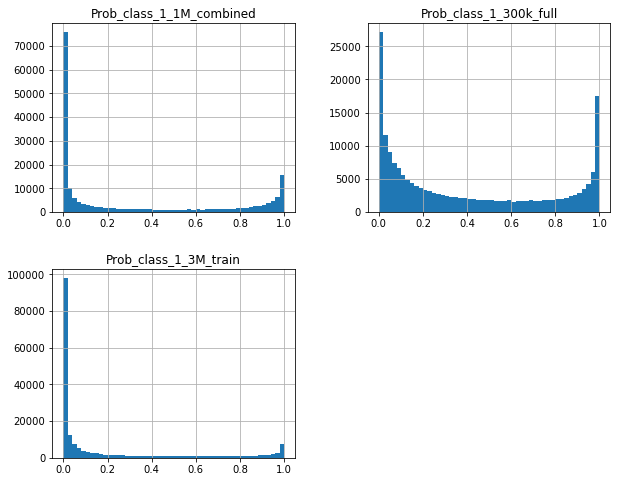

In [46]:
df_nonvirus.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fe7fb50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x130329a90>]], dtype=object)

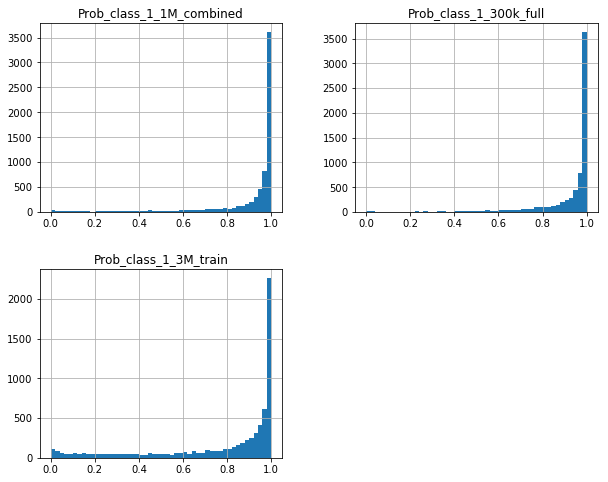

In [47]:
df_virus.hist(figsize=(10,8),column=['Prob_class_1_300k_full', 'Prob_class_1_3M_train', 'Prob_class_1_1M_combined'],bins=50)

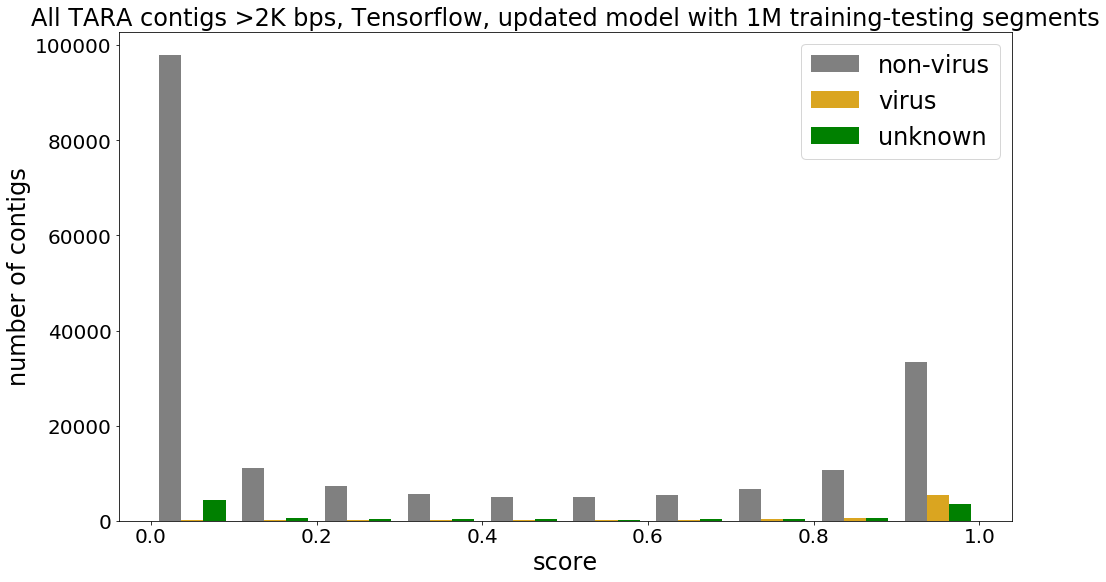

In [51]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus.Prob_class_1_1M_combined,df_virus.Prob_class_1_1M_combined,
           df_unknown.Prob_class_1_1M_combined]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus',
                                                  'virus',
                                                  'unknown'],
         color=['grey', 'goldenrod', 'green'])
ax0.set_title('All TARA contigs >2K bps, Tensorflow, updated model with 1M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

AttributeError: 'DataFrame' object has no attribute 'Prob_class_1'

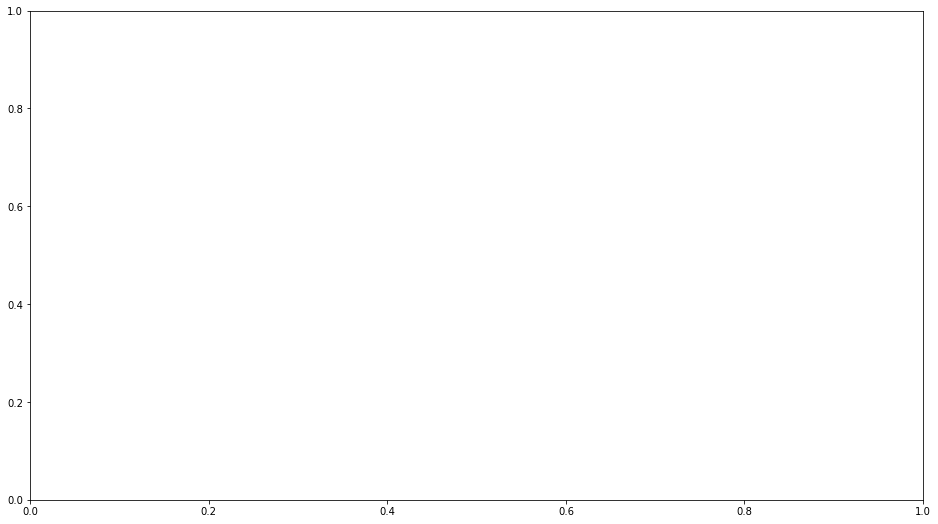

In [52]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 100
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus[df_nonvirus.Prob_class_1>0].Prob_class_1]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'non-virus'],
         color=['grey'])
ax0.set_title('"nonvirus" TARA contigs >2K bps, Tensorflow, updated model with 1M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 20
#colors = ['red', 'blue', 'grey']
x_multi = [df_virus[df_virus.Prob_class_1>0].Prob_class_1]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'virus'],
         color=['goldenrod'])
ax0.set_title('"virus" TARA contigs >2K bps, Tensorflow, updated model with 1M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

### Check the Precision-recall curve of old model and hybrid model

#### Check the distribution of probability of same number of "virus", "non-virus", 'unknown" contigs

#### Balanced data, same number of "virus" and "non-virus" contigs

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.hybrid_probability,df_virus.hybrid_probability, df_unknown_subsample.hybrid_probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, model v2.0',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.Prob_class_1_3M_train,df_virus.Prob_class_1_3M_train, df_unknown_subsample.Prob_class_1_3M_train ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, Tensorflow, updated model with 3M training-testing segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.probability,df_virus.probability,
           df_unknown_subsample.probability]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus',
                                                  'virus',
                                                  'unknown'],
         color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, model v1.0',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus.probability,df_nonvirus.hybrid_probability,df_virus.probability,
           df_virus.hybrid_probability,df_unknown.probability,df_unknown.hybrid_probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus-model_v1.0','non-virus-model_v2.0',
                                                  'virus-model_v1.0','virus-model_v2.0',
                                                  'unknown-model_v1.0','unknown-model_v2.0'],
         color=['lightgrey','grey', 'wheat','goldenrod', 'lightgreen','green'])
ax0.set_title('All TARA contigs >2K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.probability,df_nonvirus_subsample.hybrid_probability,df_virus.probability,
           df_virus.hybrid_probability,df_unknown_subsample.probability,df_unknown_subsample.hybrid_probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus-model_v1.0','non-virus-model_v2.0',
                                                  'virus-model_v1.0','virus-model_v2.0',
                                                  'unknown-model_v1.0','unknown-model_v2.0'],
         color=['lightgrey','grey', 'wheat','goldenrod', 'lightgreen','green'])
ax0.set_title('On balanced subsets of TARA contigs',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})

In [ ]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.Prob_class_1_300k_full,df_nonvirus_subsample.Prob_class_1_1M_combined,df_nonvirus_subsample.Prob_class_1_3M_train,
           df_virus.Prob_class_1_300k_full,
           df_virus.Prob_class_1_1M_combined,df_virus.Prob_class_1_3M_train,
           df_unknown_subsample.Prob_class_1_300k_full,df_unknown_subsample.Prob_class_1_1M_combined,df_unknown_subsample.Prob_class_1_3M_train ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus-300k','non-virus-1M','non-virus-3M',
                                                  'virus-300k','virus-1M','virus-3M',
                                                  'unknown-300k','unknown-1M','unknown-3M'],
         color=['lightgrey','grey', 'black','wheat','orange','goldenrod',  'lightgreen','green','darkgreen'])
ax0.set_title('On balanced subsets of TARA contigs',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})

In [ ]:
balaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus_subsample])
balaced_matrix_virus_nonvirus_hybrid = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_prediction)
auprc_balaced_virus_nonvirus_hybrid = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)
precision_balaced_virus_nonvirus_hybrid, recall_balaced_virus_nonvirus_hybrid, thresholds_balaced_virus_nonvirus_hybrid = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)

balaced_matrix_virus_nonvirus_old = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.prediction)
auprc_balaced_virus_nonvirus_old = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)
precision_balaced_virus_nonvirus_old, recall_balaced_virus_nonvirus_old, thresholds_balaced_virus_nonvirus_old = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)


        

In [ ]:
#balaced_matrix_virus_nonvirus_dl = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.Prob_class_1)
auprc_balaced_virus_nonvirus_dl = average_precision_score(balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].Prob_class_1)
precision_balaced_virus_nonvirus_dl, recall_balaced_virus_nonvirus_dl, thresholds_balaced_virus_nonvirus_dl = precision_recall_curve(
    balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].label, balaced_virus_nonvirus[balaced_virus_nonvirus.Prob_class_1>0].Prob_class_1)



In [ ]:
balaced_virus_nonvirus.head()

In [ ]:
balaced_matrix_virus_nonvirus_hybrid

In [ ]:
balaced_matrix_virus_nonvirus_old

In [ ]:
        lw = 2
        plt.figure(figsize=(16, 9), dpi=80)
        plt.clf()
        plt.plot(recall_balaced_virus_nonvirus_hybrid, precision_balaced_virus_nonvirus_hybrid, lw=lw, 
                 label='model v2.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_hybrid))
        plt.plot(recall_balaced_virus_nonvirus_old, precision_balaced_virus_nonvirus_old, lw=lw, 
                 label='model v1.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_old))
        plt.plot(recall_balaced_virus_nonvirus_dl, precision_balaced_virus_nonvirus_dl, lw=lw, 
                 label='model tensorflow, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_dl))
        plt.xlabel('Recall',fontsize=24)
        plt.ylabel('Precision',fontsize=24)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.tick_params(labelsize=20)
        plt.title('balanced virus/non-virus, 7041 contigs',fontsize=24)
        plt.legend(loc="lower right",fontsize=24)

In [ ]:
        lw = 2
        plt.figure(figsize=(16, 9), dpi=80)
        plt.clf()
        plt.plot(recall_balaced_virus_nonvirus_hybrid, precision_balaced_virus_nonvirus_hybrid, lw=lw, 
                 label='model v2.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_hybrid))
        plt.plot(recall_balaced_virus_nonvirus_old, precision_balaced_virus_nonvirus_old, lw=lw, 
                 label='model v1.0, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_old))
        plt.plot(recall_balaced_virus_nonvirus_dl, precision_balaced_virus_nonvirus_dl, lw=lw, 
                 label='model tensorflow v2, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_dl))
        plt.xlabel('Recall',fontsize=24)
        plt.ylabel('Precision',fontsize=24)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.tick_params(labelsize=20)
        plt.title('balanced virus/non-virus, 7041 contigs',fontsize=24)
        plt.legend(loc="lower right",fontsize=24)



#### using all TARA contigs - imbalanced

In [ ]:
df_virus.head()

In [ ]:

imbalaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus])
imbalaced_matrix_virus_nonvirus_hybrid = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_prediction)
auprc_imbalaced_virus_nonvirus_hybrid = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)
precision_imbalaced_virus_nonvirus_hybrid, recall_imbalaced_virus_nonvirus_hybrid, thresholds_imbalaced_virus_nonvirus_hybrid = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)

imbalaced_matrix_virus_nonvirus_old = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.prediction)
auprc_imbalaced_virus_nonvirus_old = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)
precision_imbalaced_virus_nonvirus_old, recall_imbalaced_virus_nonvirus_old, thresholds_imbalaced_virus_nonvirus_old = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)


        
    

In [ ]:
imbalaced_virus_nonvirus.head()

In [ ]:
imbalaced_matrix_virus_nonvirus_hybrid

In [ ]:
imbalaced_matrix_virus_nonvirus_old

In [ ]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_imbalaced_virus_nonvirus_hybrid, precision_imbalaced_virus_nonvirus_hybrid, lw=lw, 
                 label='hybrid model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_hybrid))
        plt.plot(recall_imbalaced_virus_nonvirus_old, precision_imbalaced_virus_nonvirus_old, lw=lw, 
                 label='old model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_old))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('imbalanced virus/non-virus, 7041:191023 contigs')
        plt.legend(loc="upper right")


### Check the performance of the Euk/non-euk model

In [ ]:
imbalaced_euk_noneuk = pd.concat([df_euk,df_noneuk])

In [ ]:
balaced_euk_noneuk = pd.concat([df_euk,df_noneuk_subsample])

In [ ]:
matrix_euk_non_euk_imbalanced = confusion_matrix(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.pred_euk_non_euk)

In [ ]:
matrix_euk_non_euk_imbalanced

In [ ]:
matrix_euk_non_euk_balanced = confusion_matrix(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.pred_euk_non_euk)

In [ ]:
matrix_euk_non_euk_balanced

In [ ]:
auprc_euk_imbalanced = average_precision_score(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [ ]:
auprc_euk_balanced = average_precision_score(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

In [ ]:
auprc_euk_balanced

In [ ]:
auprc_euk_balanced

In [ ]:
precision_euk_imbalanced, recall_euk_imbalanced, thresholds_euk_imbalanced = precision_recall_curve(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [ ]:
precision_euk_balanced, recall_euk_balanced, thresholds_euk_balanced = precision_recall_curve(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

In [ ]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_imbalanced, precision_euk_imbalanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_imbalanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, imbalanced data')
        plt.legend(loc="upper right")



In [ ]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_balanced, precision_euk_balanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_balanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, balanced data')
        plt.legend(loc="upper right")



#### Euk/non-Euk itself does not perform very well using the MEGA annotation as ground truth

#### it's still possible, the euk/non-euk works for some family......

In [ ]:
new_table[new_table.top_label=='Eukaryota'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Eukaryota related contigs')

In [ ]:
new_table2[new_table2.top_label=='Eukaryota'].Prob_class_1.plot.hist(bins=50, title='tensorflow v2, for Eukaryota related contigs')

In [ ]:
new_table[new_table.top_label!='Eukaryota'][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for non-Eukaryota related contigs')

#### This means removing low euk/non-euk score contigs, will not remove many real virus

In [ ]:
new_table[new_table.label==1].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Virus related contigs')

In [ ]:
new_table[new_table.label==0][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Non-Virus related contigs')

In [ ]:
len(new_table[new_table.probability>=0.9])

In [ ]:
len(new_table[new_table.probability>=0.9][new_table.label==1.0])

In [ ]:
len(new_table[new_table.probability>=0.9][new_table.label==0.0])

In [ ]:
len(new_table[new_table.probability<=0.1])

In [ ]:
len(new_table[new_table.probability<=0.1][new_table.label==1.0])

In [ ]:
len(new_table[new_table.probability<=0.1][new_table.label==0.0])

In [ ]:
new_table[new_table.label==1.0].probability.plot.hist(bins=50, title = 'old model, virus-related TARA contigs')

In [ ]:
ax = new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].probability.plot.hist(bins=50, title = 'old model, non-virus TARA contigs')
ax.set_xlabel("probability")

In [ ]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].probability.plot.hist(bins=50, title = 'old model, unknown TARA contigs')

In [ ]:
new_table[new_table.label==1.0].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, virus-related TARA contigs')

In [ ]:
new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, non-virus-related TARA contigs')

In [ ]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, unknown TARA contigs')

### Check the micromous -related contigs

#### most of micromonas contigs has lower euk/non-euk score, prone to be euk....

In [ ]:
df_micromonus.score_euk_non_euk.plot.hist(bins=50, title = 'model euk/non-euk, Micromonas-related TARA contigs')

In [ ]:
df_micromonus.hybrid_probability.plot.hist(bins=50, title = 'model v2.0, Micromonas-related TARA contigs')

In [ ]:
df_micromonus.probability.plot.hist(bins=50, title = 'model v1.0, Micromonas-related TARA contigs')

In [ ]:
df_micromonus[df_micromonus.Prob_class_1>0].Prob_class_1.plot.hist(bins=50, title = 'updated Tensorflow model, Micromonas-related TARA contigs')

In [ ]:
df_micromonus[df_micromonus.Prob_class_1>0].Prob_class_1.plot.hist(bins=50, title = 'updated Tensorflow model, Micromonas-related TARA contigs')

In [ ]:
sub_table = new_table.loc[:,['probability','hybrid_probability','label','tax_id','rank','tax_name']]

In [ ]:
sub_table.head()

In [ ]:
grouped = sub_table.groupby(['label'])

In [ ]:
import pandas

In [ ]:
grouped_category = new_table.groupby('category')

In [ ]:
boxplot_data_old = [new_table[new_table.category=='virus'].probability,new_table[new_table.category=='nonvirus'].probability,
               new_table[new_table.category=='unknown'].probability]

In [ ]:
plt.figure()
label_list = ['virus','non-virus','unknown']
plt.boxplot(boxplot_data_old,labels = label_list)
plt.title('old model')
plt.ylabel('probability')
plt.show()

In [ ]:
boxplot_data_hybrid = [new_table[new_table.category=='virus'].Prob_class_1,new_table2[new_table2.category=='nonvirus'].Prob_class_1,
               new_table2[new_table2.category=='unknown'].Prob_class_1]

In [ ]:
boxplot_data_dl = [new_table2[new_table2.category=='virus'].Prob_class_1.tolist(),new_table2[new_table2.category=='nonvirus'].Prob_class_1.tolist(),
               new_table2[new_table2.category=='unknown'].Prob_class_1.tolist()]

In [ ]:
plt.figure()
label_list = ['virus','non-virus','unknown']
plt.boxplot(boxplot_data_dl,labels = label_list)
plt.title('old model')
plt.ylabel('probability')
plt.show()

In [ ]:
boxplot_data_dl

In [ ]:
colors = ['goldenrod', 'grey', 'green']



fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

label_list = ['virus','non-virus','unknown']
bplot1 = ax0.boxplot(boxplot_data_hybrid,labels = label_list,patch_artist=True)
ax0.set_title('On balanced subsets of TARA transcriptome',fontsize=24)
ax0.set_ylabel('Score',fontsize=24)



for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [ ]:
colors = ['goldenrod', 'grey', 'green']



fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

label_list = ['virus','non-virus','unknown']
bplot1 = ax0.boxplot(boxplot_data_dl,labels = label_list,patch_artist=True)
ax0.set_title('On balanced subsets of TARA transcriptome, tensorflow model',fontsize=24)
ax0.set_ylabel('Score',fontsize=24)



for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [ ]:
predict_nonvirus = sub_table.groupby(['label']).get_group(0.0)

In [ ]:
predict_nonvirus.head()

In [ ]:
predict_nonvirus[predict_nonvirus.probability>0.99].describe()

In [ ]:
grouped = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']].groupby(['rank'])

In [ ]:
predict_nonvirus_rank = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']]

In [ ]:
def convert_rank(rank):
    if rank == 'no rank':
        return 'no rank'
    else:
        return 'rank'
    

In [ ]:
predict_nonvirus_rank['no_rank'] = predict_nonvirus_rank['rank'].map(convert_rank)

In [ ]:
predict_nonvirus_rank.head()

In [ ]:
predict_nonvirus_rank_subset = predict_nonvirus_rank[(predict_nonvirus_rank['rank'] =='class') | (predict_nonvirus_rank['rank'] =='family') | (predict_nonvirus_rank['rank'] =='genus')\
                      | (predict_nonvirus_rank['rank'] =='kingdom')| (predict_nonvirus_rank['rank'] =='no rank')| (predict_nonvirus_rank['rank'] =='order')\
                      | (predict_nonvirus_rank['rank'] =='phylum')| (predict_nonvirus_rank['rank'] =='species')| (predict_nonvirus_rank['rank'] =='superkingdom')]


In [ ]:
predict_nonvirus_rank_grouped = predict_nonvirus_rank.groupby(['no_rank'])

In [ ]:
predict_nonvirus_rank_grouped.describe()

In [ ]:
predict_nonvirus_rank_grouped.boxplot(column=['hybrid_probability'])

In [ ]:
predict_nonvirus_rank_grouped.boxplot(column=['probability'])

In [ ]:
9169.0/111440

In [ ]:
tax_name_count_99 = predict_nonvirus[predict_nonvirus.probability>0.99].groupby('tax_name').size().reset_index()

In [ ]:
tax_name_count_99['percent_99'] = tax_name_count_99[0].apply(lambda x: 100*x/float(tax_name_count_99.sum()))

In [ ]:
tax_name_count_99.head()

In [ ]:
tax_name_count_01 = predict_nonvirus[predict_nonvirus.probability<0.01].groupby('tax_name').size().reset_index()

In [ ]:
tax_name_count_01['percent_01'] = tax_name_count_01[0].apply(lambda x: 100*x/float(tax_name_count_01.sum()))

In [ ]:
tax_name_count_01.head()


In [ ]:
tax_name = pd.merge(tax_name_count_99,tax_name_count_01,how='inner',on=['tax_name'])

In [ ]:
tax_name.head()

In [ ]:
tax_name['increase'] = tax_name.apply(lambda x:x['percent_99']/x['percent_01'], axis=1)

In [ ]:
tax_name.sort_values(by='increase')

In [ ]:
tax_name.sort_values(by='percent_99')

In [ ]:
1587.0/31057

In [ ]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('tax_id').size()

In [ ]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('rank').size()

In [ ]:
predict_nonvirus[predict_nonvirus.probability<0.1].groupby('rank').size()

In [ ]:
predict_virus = sub_table.groupby(['label']).get_group(1.0)

In [ ]:
result = pd.read_csv('/Users/qingpeng/shred.fa.score',sep=' ',header=None,names=['probability','prediction'])

In [ ]:
result

In [ ]:
result.probability.plot.hist(bins=100)